# Circuit learning module: Lambeq manually with SPSA and JAX

This module performs the optimization of the parametrized circuit manually compared to Lambeq's automatic QuantumTrainer class. I created this because I wanted to have more control over the optimization process and debug it better. The code is based on the workflow presented in https://github.com/CQCL/Quanthoven.

In [1]:
import warnings
import json
import os
import sys
import glob
from math import ceil
from pathlib import Path
from jax import numpy as np
from sympy import default_sort_key
import numpy
import pickle
import matplotlib.pyplot as plt

import jax
from jax import jit
from noisyopt import minimizeSPSA, minimizeCompass

from discopy.quantum import Circuit
from discopy.tensor import Tensor
from discopy.utils import loads
#from pytket.extensions.qiskit import AerBackend
#from pytket.extensions.qulacs import QulacsBackend
#from pytket.extensions.cirq import CirqStateSampleBackend
backend = None

from utils import get_symbols, construct_data_and_labels, select_circuits, read_diagrams, create_labeled_classes, bin_class_loss, multi_class_loss, bin_class_acc, multi_class_acc, visualize_result_noisyopt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

warnings.filterwarnings('ignore')
this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'
#os.environ["JAX_PLATFORMS"] = "cpu"

EPOCHS = 500
SEED = 0

# This avoids TracerArrayConversionError from jax
Tensor.np = np

rng = numpy.random.default_rng(SEED)
numpy.random.seed(SEED)

## Read circuit data

We read the circuits from the pickled files. Select if we perform binary classification or multi-class classification. Give number of qubits to create classes:
- 1 qubits -> 2^1 = 2 classes i.e. binary classification
- 2 qubits -> 2^2 = 4 classes
- ...
- 5 qubits -> 2^5 = 32 classes, etc.

In [2]:
# Select workload
workload = "execution_time"
#workload = "cardinality"

# Select workload size
#workload_size = "small"
#workload_size = "medium"
#workload_size = "large"
workload_size = "main"

classification = 1
layers = 1
single_qubit_params = 3
n_wire_count = 1

loss = multi_class_loss
acc = multi_class_acc

if classification == 1:
    loss = bin_class_loss
    acc = bin_class_acc

# Access the selected circuits
path_name = this_folder + "//simplified-JOB-diagrams//" + workload + "//" + workload_size + "//circuits//" + str(classification) + "//" + str(layers) + "_layer//" + str(single_qubit_params) + "_single_qubit_params//" + str(n_wire_count) + "_n_wire_count//"

training_circuits_paths = glob.glob(path_name + "training//[0-9]*.p")
validation_circuits_paths = glob.glob(path_name + "validation//[0-9]*.p")
test_circuits_paths = glob.glob(path_name + "test//[0-9]*.p")

In [3]:
training_circuits = read_diagrams(training_circuits_paths)
validation_circuits = read_diagrams(validation_circuits_paths)
test_circuits = read_diagrams(test_circuits_paths)

## Read training and test data

In [4]:
training_data, test_data, validation_data = None, None, None
data_path = this_folder + "//data//" + workload + "//" + workload_size + "//"

with open(data_path + "training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(data_path + "test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
with open(data_path + "validation_data.json", "r") as inputfile:
    validation_data = json.load(inputfile)['validation_data']

training_data_labels = create_labeled_classes(training_data, classification)
test_data_labels = create_labeled_classes(test_data, classification)
validation_data_labels = create_labeled_classes(validation_data, classification)

## Lambeq optimizer

## Model

In [5]:
def make_pred_fn(circuits):
    # In the case we want to use other backends. 
    # Currently does not work properly.
    if backend:
        compiled_circuits1 = backend.get_compiled_circuits([c.to_tk() for c in circuits])
        circuits = [Circuit.from_tk(c) for c in compiled_circuits1]
        
    circuit_fns = [c.lambdify(*parameters) for c in circuits]
    
    def predict(params):
        outputs = Circuit.eval(*(c(*params) for c in circuit_fns), backend = backend)
        res = []
        
        for output in outputs:
            predictions = np.abs(output.array) + 1e-9
            ratio = predictions / predictions.sum()
            res.append(ratio)
            
        return np.array(res)
    return predict

## Loss function and evaluation

In [6]:
def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = loss(predictions, labels) #-np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        accuracy = acc(predictions, labels) #np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(accuracy)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies

## Minimization with noisyopt

In [7]:
def initialize_parameters(old_params, old_values, new_params):
    new_values = list(numpy.array(rng.random(len(new_params))))
    old_param_dict = {}
    for p, v in zip(old_params, old_values):
        old_param_dict[p] = v
        
    parameters = sorted(set(old_params + new_params), key=default_sort_key)
    values = []
    for p in parameters:
        if p in old_param_dict:
            values.append(old_param_dict[p])
        else:
            values.append(new_values.pop())
            
    return parameters, np.array(values)

In [8]:
def grid_search():
    return None

Progress:  0.022
Number of training circuits: 10    Number of validation circuits: 45    Number of test circuits: 42    Number of parameters in model: 161


Epoch: 100    train/loss: 0.364    valid/loss: 0.6481    train/acc: 0.9    valid/acc: 0.5778
Epoch: 200    train/loss: 0.2841    valid/loss: 0.6171    train/acc: 0.9    valid/acc: 0.6222
Epoch: 300    train/loss: 0.2635    valid/loss: 0.6171    train/acc: 0.9    valid/acc: 0.6222
Epoch: 400    train/loss: 0.215    valid/loss: 0.6237    train/acc: 1.0    valid/acc: 0.6667
Epoch: 500    train/loss: 0.2114    valid/loss: 0.6084    train/acc: 1.0    valid/acc: 0.6444


Test accuracy: 0.64285713
Progress:  0.025
Number of training circuits: 11    Number of validation circuits: 47    Number of test circuits: 46    Number of parameters in model: 173


Epoch: 100    train/loss: 0.2658    valid/loss: 0.707    train/acc: 1.0    valid/acc: 0.5319
Epoch: 200    train/loss: 0.196    valid/loss: 0.7364    train/acc: 1.0    valid/acc: 0.5532
Epoch: 300    train/loss: 0.1821    valid/loss: 0.7283    train/acc: 1.0    valid/acc: 0.5319
Epoch: 400    train/loss: 0.1555    valid/loss: 0.7487    train/acc: 1.0    valid/acc: 0.4894
Epoch: 500    train/loss: 0.1354    valid/loss: 0.7856    train/acc: 1.0    valid/acc: 0.4894
Epoch: 600    train/loss: 0.1246    valid/loss: 0.7734    train/acc: 1.0    valid/acc: 0.5106
Epoch: 700    train/loss: 0.1051    valid/loss: 0.8154    train/acc: 1.0    valid/acc: 0.4894


Test accuracy: 0.65217394
Progress:  0.027
Progress:  0.029
Progress:  0.031
Number of training circuits: 13    Number of validation circuits: 53    Number of test circuits: 52    Number of parameters in model: 190


Epoch: 100    train/loss: 0.2202    valid/loss: 0.7738    train/acc: 1.0    valid/acc: 0.5849
Epoch: 200    train/loss: 0.1212    valid/loss: 0.8094    train/acc: 1.0    valid/acc: 0.6038
Epoch: 300    train/loss: 0.118    valid/loss: 0.8235    train/acc: 1.0    valid/acc: 0.5849
Epoch: 400    train/loss: 0.1112    valid/loss: 0.8036    train/acc: 1.0    valid/acc: 0.5849
Epoch: 500    train/loss: 0.1027    valid/loss: 0.8107    train/acc: 1.0    valid/acc: 0.566
Epoch: 600    train/loss: 0.0971    valid/loss: 0.8528    train/acc: 1.0    valid/acc: 0.566
Epoch: 700    train/loss: 0.099    valid/loss: 0.8579    train/acc: 1.0    valid/acc: 0.5849
Epoch: 800    train/loss: 0.0968    valid/loss: 0.8573    train/acc: 1.0    valid/acc: 0.6038
Epoch: 900    train/loss: 0.0766    valid/loss: 0.8478    train/acc: 1.0    valid/acc: 0.5849


Test accuracy: 0.5769231
Progress:  0.033
Number of training circuits: 14    Number of validation circuits: 70    Number of test circuits: 64    Number of parameters in model: 193


Epoch: 100    train/loss: 0.2316    valid/loss: 1.0474    train/acc: 0.9286    valid/acc: 0.4286
Epoch: 200    train/loss: 0.1339    valid/loss: 1.0956    train/acc: 1.0    valid/acc: 0.4714
Epoch: 300    train/loss: 0.1005    valid/loss: 1.1865    train/acc: 1.0    valid/acc: 0.4857
Epoch: 400    train/loss: 0.0712    valid/loss: 1.1296    train/acc: 1.0    valid/acc: 0.5
Epoch: 500    train/loss: 0.0474    valid/loss: 1.1694    train/acc: 1.0    valid/acc: 0.5
Epoch: 600    train/loss: 0.0557    valid/loss: 1.0746    train/acc: 1.0    valid/acc: 0.5286
Epoch: 700    train/loss: 0.0484    valid/loss: 1.1521    train/acc: 1.0    valid/acc: 0.5286
Epoch: 800    train/loss: 0.0528    valid/loss: 1.161    train/acc: 1.0    valid/acc: 0.5
Epoch: 900    train/loss: 0.0405    valid/loss: 1.1583    train/acc: 1.0    valid/acc: 0.5
Epoch: 1000    train/loss: 0.0405    valid/loss: 1.2137    train/acc: 1.0    valid/acc: 0.5143
Epoch: 1100    train/loss: 0.0354    valid/loss: 1.1935    train/acc:

Test accuracy: 0.625
Progress:  0.036
Progress:  0.038
Number of training circuits: 16    Number of validation circuits: 73    Number of test circuits: 67    Number of parameters in model: 196


Epoch: 100    train/loss: 0.3332    valid/loss: 0.99    train/acc: 0.9375    valid/acc: 0.3836
Epoch: 200    train/loss: 0.2408    valid/loss: 0.9892    train/acc: 0.9375    valid/acc: 0.3836
Epoch: 300    train/loss: 0.215    valid/loss: 0.9667    train/acc: 0.9375    valid/acc: 0.3836
Epoch: 400    train/loss: 0.1939    valid/loss: 0.9844    train/acc: 0.9375    valid/acc: 0.3836
Epoch: 500    train/loss: 0.2035    valid/loss: 0.9491    train/acc: 0.9375    valid/acc: 0.3699
Epoch: 600    train/loss: 0.1841    valid/loss: 0.9762    train/acc: 0.9375    valid/acc: 0.3836
Epoch: 700    train/loss: 0.1755    valid/loss: 0.9387    train/acc: 0.9375    valid/acc: 0.3836
Epoch: 800    train/loss: 0.1713    valid/loss: 0.9477    train/acc: 0.9375    valid/acc: 0.3836
Epoch: 900    train/loss: 0.1644    valid/loss: 0.9578    train/acc: 1.0    valid/acc: 0.411
Epoch: 1000    train/loss: 0.152    valid/loss: 0.9684    train/acc: 1.0    valid/acc: 0.4384
Epoch: 1100    train/loss: 0.1454    val

Test accuracy: 0.53731346
Progress:  0.04
Progress:  0.042
Number of training circuits: 18    Number of validation circuits: 85    Number of test circuits: 74    Number of parameters in model: 199


Epoch: 100    train/loss: 0.2349    valid/loss: 0.9624    train/acc: 1.0    valid/acc: 0.4235
Epoch: 200    train/loss: 0.204    valid/loss: 0.9955    train/acc: 1.0    valid/acc: 0.4235
Epoch: 300    train/loss: 0.1984    valid/loss: 1.0141    train/acc: 1.0    valid/acc: 0.4235
Epoch: 400    train/loss: 0.1986    valid/loss: 0.9371    train/acc: 1.0    valid/acc: 0.4471
Epoch: 500    train/loss: 0.2092    valid/loss: 1.0094    train/acc: 1.0    valid/acc: 0.4235
Epoch: 600    train/loss: 0.1662    valid/loss: 0.9532    train/acc: 1.0    valid/acc: 0.4353
Epoch: 700    train/loss: 0.1847    valid/loss: 0.9438    train/acc: 1.0    valid/acc: 0.4471
Epoch: 800    train/loss: 0.1772    valid/loss: 0.9811    train/acc: 1.0    valid/acc: 0.4353
Epoch: 900    train/loss: 0.1542    valid/loss: 0.9774    train/acc: 1.0    valid/acc: 0.4235
Epoch: 1000    train/loss: 0.1396    valid/loss: 0.9987    train/acc: 1.0    valid/acc: 0.4353
Epoch: 1100    train/loss: 0.1407    valid/loss: 0.987    tr

Test accuracy: 0.58108103
Progress:  0.045
Number of training circuits: 19    Number of validation circuits: 87    Number of test circuits: 78    Number of parameters in model: 205


Epoch: 100    train/loss: 0.2003    valid/loss: 0.9134    train/acc: 0.9474    valid/acc: 0.4943
Epoch: 200    train/loss: 0.1674    valid/loss: 0.8913    train/acc: 1.0    valid/acc: 0.4598
Epoch: 300    train/loss: 0.1599    valid/loss: 0.878    train/acc: 1.0    valid/acc: 0.4483
Epoch: 400    train/loss: 0.1503    valid/loss: 0.8685    train/acc: 1.0    valid/acc: 0.4598
Epoch: 500    train/loss: 0.1555    valid/loss: 0.8841    train/acc: 1.0    valid/acc: 0.4253
Epoch: 600    train/loss: 0.1357    valid/loss: 0.866    train/acc: 1.0    valid/acc: 0.4713
Epoch: 700    train/loss: 0.142    valid/loss: 0.8586    train/acc: 1.0    valid/acc: 0.4598
Epoch: 800    train/loss: 0.1247    valid/loss: 0.8589    train/acc: 1.0    valid/acc: 0.4828
Epoch: 900    train/loss: 0.1288    valid/loss: 0.8563    train/acc: 1.0    valid/acc: 0.4598
Epoch: 1000    train/loss: 0.1288    valid/loss: 0.8549    train/acc: 1.0    valid/acc: 0.4483
Epoch: 1100    train/loss: 0.1229    valid/loss: 0.8437    

Test accuracy: 0.5769231
Progress:  0.047
Number of training circuits: 20    Number of validation circuits: 87    Number of test circuits: 81    Number of parameters in model: 208


Epoch: 100    train/loss: 0.1818    valid/loss: 0.8207    train/acc: 1.0    valid/acc: 0.4713
Epoch: 200    train/loss: 0.1891    valid/loss: 0.8884    train/acc: 1.0    valid/acc: 0.4828
Epoch: 300    train/loss: 0.163    valid/loss: 0.8602    train/acc: 1.0    valid/acc: 0.4713
Epoch: 400    train/loss: 0.1855    valid/loss: 0.8976    train/acc: 1.0    valid/acc: 0.4368
Epoch: 500    train/loss: 0.1797    valid/loss: 0.9106    train/acc: 1.0    valid/acc: 0.4483
Epoch: 600    train/loss: 0.2017    valid/loss: 0.8795    train/acc: 0.95    valid/acc: 0.5057
Epoch: 700    train/loss: 0.1751    valid/loss: 0.9077    train/acc: 0.95    valid/acc: 0.4828
Epoch: 800    train/loss: 0.1507    valid/loss: 0.9113    train/acc: 1.0    valid/acc: 0.4943
Epoch: 900    train/loss: 0.152    valid/loss: 0.8933    train/acc: 1.0    valid/acc: 0.4943
Epoch: 1000    train/loss: 0.1357    valid/loss: 0.9146    train/acc: 1.0    valid/acc: 0.4598
Epoch: 1100    train/loss: 0.1355    valid/loss: 0.9385    

Test accuracy: 0.5925926
Progress:  0.049
Number of training circuits: 21    Number of validation circuits: 87    Number of test circuits: 84    Number of parameters in model: 211


Epoch: 100    train/loss: 0.2032    valid/loss: 0.9743    train/acc: 1.0    valid/acc: 0.4828
Epoch: 200    train/loss: 0.1762    valid/loss: 0.9188    train/acc: 1.0    valid/acc: 0.4828
Epoch: 300    train/loss: 0.159    valid/loss: 0.9458    train/acc: 1.0    valid/acc: 0.5172
Epoch: 400    train/loss: 0.1732    valid/loss: 0.9381    train/acc: 1.0    valid/acc: 0.4943
Epoch: 500    train/loss: 0.1687    valid/loss: 0.8726    train/acc: 1.0    valid/acc: 0.5057
Epoch: 600    train/loss: 0.1931    valid/loss: 0.9043    train/acc: 1.0    valid/acc: 0.4713
Epoch: 700    train/loss: 0.1776    valid/loss: 0.983    train/acc: 1.0    valid/acc: 0.4828
Epoch: 800    train/loss: 0.1708    valid/loss: 0.9751    train/acc: 1.0    valid/acc: 0.4483
Epoch: 900    train/loss: 0.1539    valid/loss: 0.9952    train/acc: 1.0    valid/acc: 0.4598
Epoch: 1000    train/loss: 0.1409    valid/loss: 1.0215    train/acc: 1.0    valid/acc: 0.4368
Epoch: 1100    train/loss: 0.1645    valid/loss: 1.0122    tr

Test accuracy: 0.64285713
Progress:  0.051
Progress:  0.054
Progress:  0.056
Progress:  0.058
Progress:  0.06
Number of training circuits: 26    Number of validation circuits: 90    Number of test circuits: 89    Number of parameters in model: 214


Epoch: 100    train/loss: 0.2059    valid/loss: 0.9736    train/acc: 0.9615    valid/acc: 0.4667
Epoch: 200    train/loss: 0.1576    valid/loss: 0.964    train/acc: 1.0    valid/acc: 0.4667
Epoch: 300    train/loss: 0.1537    valid/loss: 0.9214    train/acc: 1.0    valid/acc: 0.4667
Epoch: 400    train/loss: 0.1357    valid/loss: 0.8739    train/acc: 1.0    valid/acc: 0.4889
Epoch: 500    train/loss: 0.1297    valid/loss: 0.8791    train/acc: 1.0    valid/acc: 0.4778
Epoch: 600    train/loss: 0.1289    valid/loss: 0.8701    train/acc: 1.0    valid/acc: 0.5
Epoch: 700    train/loss: 0.1293    valid/loss: 0.9092    train/acc: 1.0    valid/acc: 0.4778
Epoch: 800    train/loss: 0.1177    valid/loss: 0.9224    train/acc: 1.0    valid/acc: 0.5
Epoch: 900    train/loss: 0.1182    valid/loss: 0.9253    train/acc: 1.0    valid/acc: 0.5111
Epoch: 1000    train/loss: 0.1127    valid/loss: 0.9127    train/acc: 1.0    valid/acc: 0.5111
Epoch: 1100    train/loss: 0.1087    valid/loss: 0.8581    trai

Test accuracy: 0.61797756
Progress:  0.062
Number of training circuits: 27    Number of validation circuits: 93    Number of test circuits: 90    Number of parameters in model: 217


Epoch: 100    train/loss: 0.1143    valid/loss: 0.869    train/acc: 1.0    valid/acc: 0.5161
Epoch: 200    train/loss: 0.0902    valid/loss: 0.8672    train/acc: 1.0    valid/acc: 0.5054
Epoch: 300    train/loss: 0.1021    valid/loss: 0.938    train/acc: 1.0    valid/acc: 0.5161
Epoch: 400    train/loss: 0.079    valid/loss: 0.9508    train/acc: 1.0    valid/acc: 0.5054
Epoch: 500    train/loss: 0.0753    valid/loss: 0.9613    train/acc: 1.0    valid/acc: 0.4839
Epoch: 600    train/loss: 0.0713    valid/loss: 0.9823    train/acc: 1.0    valid/acc: 0.4839
Epoch: 700    train/loss: 0.0767    valid/loss: 1.0029    train/acc: 1.0    valid/acc: 0.4839
Epoch: 800    train/loss: 0.0738    valid/loss: 0.9868    train/acc: 1.0    valid/acc: 0.4946
Epoch: 900    train/loss: 0.0801    valid/loss: 0.9952    train/acc: 1.0    valid/acc: 0.4946
Epoch: 1000    train/loss: 0.0721    valid/loss: 1.0084    train/acc: 1.0    valid/acc: 0.5054
Epoch: 1100    train/loss: 0.0735    valid/loss: 0.9438    tra

Test accuracy: 0.6333333
Progress:  0.065
Progress:  0.067
Progress:  0.069
Number of training circuits: 30    Number of validation circuits: 96    Number of test circuits: 92    Number of parameters in model: 223


Epoch: 100    train/loss: 0.176    valid/loss: 0.9714    train/acc: 0.9333    valid/acc: 0.5312
Epoch: 200    train/loss: 0.1703    valid/loss: 0.9719    train/acc: 0.9333    valid/acc: 0.5417
Epoch: 300    train/loss: 0.1607    valid/loss: 0.9344    train/acc: 0.9333    valid/acc: 0.5625
Epoch: 400    train/loss: 0.1497    valid/loss: 0.8968    train/acc: 0.9333    valid/acc: 0.6042
Epoch: 500    train/loss: 0.1425    valid/loss: 0.8663    train/acc: 0.9333    valid/acc: 0.6146
Epoch: 600    train/loss: 0.1432    valid/loss: 0.931    train/acc: 0.9333    valid/acc: 0.6146
Epoch: 700    train/loss: 0.1432    valid/loss: 0.8799    train/acc: 0.9333    valid/acc: 0.6042
Epoch: 800    train/loss: 0.1333    valid/loss: 0.9166    train/acc: 0.9333    valid/acc: 0.6146
Epoch: 900    train/loss: 0.129    valid/loss: 0.9045    train/acc: 0.9333    valid/acc: 0.5938
Epoch: 1000    train/loss: 0.1275    valid/loss: 0.8921    train/acc: 0.9333    valid/acc: 0.5938
Epoch: 1100    train/loss: 0.124

Test accuracy: 0.6304348
Progress:  0.071
Progress:  0.074
Progress:  0.076
Progress:  0.078
Progress:  0.08
Number of training circuits: 35    Number of validation circuits: 97    Number of test circuits: 96    Number of parameters in model: 229


Epoch: 100    train/loss: 0.1618    valid/loss: 0.9709    train/acc: 0.9429    valid/acc: 0.5155
Epoch: 200    train/loss: 0.1572    valid/loss: 0.9971    train/acc: 0.9429    valid/acc: 0.5155
Epoch: 300    train/loss: 0.1551    valid/loss: 1.0094    train/acc: 0.9429    valid/acc: 0.5052
Epoch: 400    train/loss: 0.153    valid/loss: 1.0022    train/acc: 0.9429    valid/acc: 0.5155
Epoch: 500    train/loss: 0.1521    valid/loss: 1.0209    train/acc: 0.9429    valid/acc: 0.5155
Epoch: 600    train/loss: 0.1474    valid/loss: 1.0195    train/acc: 0.9429    valid/acc: 0.5258
Epoch: 700    train/loss: 0.1459    valid/loss: 1.0233    train/acc: 0.9429    valid/acc: 0.5258
Epoch: 800    train/loss: 0.1463    valid/loss: 1.0313    train/acc: 0.9429    valid/acc: 0.5155
Epoch: 900    train/loss: 0.1414    valid/loss: 1.0313    train/acc: 0.9429    valid/acc: 0.5258
Epoch: 1000    train/loss: 0.141    valid/loss: 1.0343    train/acc: 0.9429    valid/acc: 0.5155
Epoch: 1100    train/loss: 0.13

Test accuracy: 0.625
Progress:  0.083
Progress:  0.085
Progress:  0.087
Progress:  0.089
Number of training circuits: 39    Number of validation circuits: 101    Number of test circuits: 101    Number of parameters in model: 232


Epoch: 100    train/loss: 0.1994    valid/loss: 0.9674    train/acc: 0.8974    valid/acc: 0.5149
Epoch: 200    train/loss: 0.1782    valid/loss: 0.9524    train/acc: 0.9231    valid/acc: 0.5743
Epoch: 300    train/loss: 0.1821    valid/loss: 0.9585    train/acc: 0.9231    valid/acc: 0.5248
Epoch: 400    train/loss: 0.1815    valid/loss: 0.8814    train/acc: 0.9231    valid/acc: 0.5545
Epoch: 500    train/loss: 0.1725    valid/loss: 0.9177    train/acc: 0.9231    valid/acc: 0.5644
Epoch: 600    train/loss: 0.1714    valid/loss: 0.9194    train/acc: 0.9231    valid/acc: 0.5446
Epoch: 700    train/loss: 0.1713    valid/loss: 0.9083    train/acc: 0.9231    valid/acc: 0.5644
Epoch: 800    train/loss: 0.1655    valid/loss: 0.9461    train/acc: 0.9231    valid/acc: 0.5842
Epoch: 900    train/loss: 0.1662    valid/loss: 0.9249    train/acc: 0.9231    valid/acc: 0.5446
Epoch: 1000    train/loss: 0.1635    valid/loss: 0.9494    train/acc: 0.9231    valid/acc: 0.5842
Epoch: 1100    train/loss: 0.

Test accuracy: 0.6138614
Progress:  0.092
Number of training circuits: 40    Number of validation circuits: 104    Number of test circuits: 104    Number of parameters in model: 235


Epoch: 100    train/loss: 0.1517    valid/loss: 0.9182    train/acc: 0.975    valid/acc: 0.5577
Epoch: 200    train/loss: 0.1449    valid/loss: 0.8764    train/acc: 0.975    valid/acc: 0.5673
Epoch: 300    train/loss: 0.1309    valid/loss: 0.9101    train/acc: 0.975    valid/acc: 0.5481
Epoch: 400    train/loss: 0.1316    valid/loss: 0.8812    train/acc: 0.975    valid/acc: 0.5577
Epoch: 500    train/loss: 0.1294    valid/loss: 0.9083    train/acc: 0.975    valid/acc: 0.5481
Epoch: 600    train/loss: 0.1286    valid/loss: 0.9209    train/acc: 0.975    valid/acc: 0.5385
Epoch: 700    train/loss: 0.1342    valid/loss: 0.8845    train/acc: 0.975    valid/acc: 0.5385
Epoch: 800    train/loss: 0.1237    valid/loss: 0.9324    train/acc: 0.975    valid/acc: 0.5481
Epoch: 900    train/loss: 0.1271    valid/loss: 0.8981    train/acc: 0.975    valid/acc: 0.5673
Epoch: 1000    train/loss: 0.1211    valid/loss: 0.9749    train/acc: 0.975    valid/acc: 0.5577
Epoch: 1100    train/loss: 0.1223    va

Test accuracy: 0.6346154
Progress:  0.094
Progress:  0.096
Progress:  0.098
Progress:  0.1
Progress:  0.103
Progress:  0.105
Progress:  0.107
Progress:  0.109
Progress:  0.112
Progress:  0.114
Progress:  0.116
Progress:  0.118
Progress:  0.121
Progress:  0.123
Progress:  0.125
Progress:  0.127
Progress:  0.129
Progress:  0.132
Number of training circuits: 58    Number of validation circuits: 108    Number of test circuits: 108    Number of parameters in model: 238


Epoch: 100    train/loss: 0.2832    valid/loss: 0.7862    train/acc: 0.9138    valid/acc: 0.6204
Epoch: 200    train/loss: 0.2512    valid/loss: 0.8231    train/acc: 0.931    valid/acc: 0.6389
Epoch: 300    train/loss: 0.2422    valid/loss: 0.839    train/acc: 0.931    valid/acc: 0.6204
Epoch: 400    train/loss: 0.2332    valid/loss: 0.8052    train/acc: 0.931    valid/acc: 0.6111
Epoch: 500    train/loss: 0.2301    valid/loss: 0.7678    train/acc: 0.931    valid/acc: 0.6204
Epoch: 600    train/loss: 0.2223    valid/loss: 0.7778    train/acc: 0.931    valid/acc: 0.6296
Epoch: 700    train/loss: 0.2215    valid/loss: 0.7711    train/acc: 0.931    valid/acc: 0.6389
Epoch: 800    train/loss: 0.2179    valid/loss: 0.8    train/acc: 0.931    valid/acc: 0.6111
Epoch: 900    train/loss: 0.2168    valid/loss: 0.7788    train/acc: 0.931    valid/acc: 0.6019
Epoch: 1000    train/loss: 0.2103    valid/loss: 0.7963    train/acc: 0.931    valid/acc: 0.6019
Epoch: 1100    train/loss: 0.2121    valid

Test accuracy: 0.6296296
Progress:  0.134
Progress:  0.136
Progress:  0.138
Progress:  0.141
Progress:  0.143
Progress:  0.145
Progress:  0.147
Progress:  0.15
Progress:  0.152
Progress:  0.154
Progress:  0.156
Progress:  0.158
Progress:  0.161
Progress:  0.163
Progress:  0.165
Progress:  0.167
Progress:  0.17
Progress:  0.172
Progress:  0.174
Progress:  0.176
Progress:  0.179
Progress:  0.181
Progress:  0.183
Progress:  0.185
Progress:  0.188
Progress:  0.19
Progress:  0.192
Progress:  0.194
Progress:  0.196
Progress:  0.199
Progress:  0.201
Progress:  0.203
Progress:  0.205
Progress:  0.208
Progress:  0.21
Progress:  0.212
Progress:  0.214
Progress:  0.217
Progress:  0.219
Progress:  0.221
Progress:  0.223
Progress:  0.225
Progress:  0.228
Number of training circuits: 101    Number of validation circuits: 108    Number of test circuits: 108    Number of parameters in model: 241


Epoch: 100    train/loss: 0.3814    valid/loss: 0.6472    train/acc: 0.8515    valid/acc: 0.6852
Epoch: 200    train/loss: 0.3639    valid/loss: 0.6552    train/acc: 0.8713    valid/acc: 0.6852
Epoch: 300    train/loss: 0.3612    valid/loss: 0.6232    train/acc: 0.8713    valid/acc: 0.7222
Epoch: 400    train/loss: 0.3519    valid/loss: 0.6548    train/acc: 0.8614    valid/acc: 0.7037
Epoch: 500    train/loss: 0.3419    valid/loss: 0.6541    train/acc: 0.8614    valid/acc: 0.75
Epoch: 600    train/loss: 0.3402    valid/loss: 0.6605    train/acc: 0.8812    valid/acc: 0.7593
Epoch: 700    train/loss: 0.3338    valid/loss: 0.6647    train/acc: 0.8911    valid/acc: 0.7407
Epoch: 800    train/loss: 0.3298    valid/loss: 0.6659    train/acc: 0.8911    valid/acc: 0.7407
Epoch: 900    train/loss: 0.3308    valid/loss: 0.6548    train/acc: 0.8911    valid/acc: 0.7315
Epoch: 1000    train/loss: 0.3283    valid/loss: 0.643    train/acc: 0.8812    valid/acc: 0.75
Epoch: 1100    train/loss: 0.3284 

Test accuracy: 0.6481482
Progress:  0.23
Progress:  0.232
Progress:  0.234
Progress:  0.237
Progress:  0.239
Progress:  0.241
Progress:  0.243
Progress:  0.246
Progress:  0.248
Progress:  0.25
Progress:  0.252
Progress:  0.254
Progress:  0.257
Progress:  0.259
Progress:  0.261
Progress:  0.263
Progress:  0.266
Progress:  0.268
Progress:  0.27
Progress:  0.272
Progress:  0.275
Number of training circuits: 122    Number of validation circuits: 109    Number of test circuits: 109    Number of parameters in model: 244


Epoch: 100    train/loss: 0.374    valid/loss: 0.6811    train/acc: 0.8443    valid/acc: 0.7064
Epoch: 200    train/loss: 0.3575    valid/loss: 0.685    train/acc: 0.8525    valid/acc: 0.6697
Epoch: 300    train/loss: 0.3521    valid/loss: 0.6754    train/acc: 0.877    valid/acc: 0.6514
Epoch: 400    train/loss: 0.3471    valid/loss: 0.6794    train/acc: 0.877    valid/acc: 0.6422
Epoch: 500    train/loss: 0.345    valid/loss: 0.6981    train/acc: 0.8689    valid/acc: 0.6514
Epoch: 600    train/loss: 0.3406    valid/loss: 0.6854    train/acc: 0.8689    valid/acc: 0.6422
Epoch: 700    train/loss: 0.3384    valid/loss: 0.6914    train/acc: 0.8689    valid/acc: 0.6422
Epoch: 800    train/loss: 0.3368    valid/loss: 0.6927    train/acc: 0.877    valid/acc: 0.6422
Epoch: 900    train/loss: 0.3353    valid/loss: 0.6848    train/acc: 0.877    valid/acc: 0.6606
Epoch: 1000    train/loss: 0.3332    valid/loss: 0.6857    train/acc: 0.877    valid/acc: 0.6514
Epoch: 1100    train/loss: 0.3329    

Test accuracy: 0.6422018
Progress:  0.277
Progress:  0.279
Number of training circuits: 124    Number of validation circuits: 110    Number of test circuits: 109    Number of parameters in model: 253


Epoch: 100    train/loss: 0.3279    valid/loss: 0.6431    train/acc: 0.8548    valid/acc: 0.7182
Epoch: 200    train/loss: 0.3215    valid/loss: 0.661    train/acc: 0.879    valid/acc: 0.7182
Epoch: 300    train/loss: 0.3187    valid/loss: 0.6551    train/acc: 0.871    valid/acc: 0.7273
Epoch: 400    train/loss: 0.3175    valid/loss: 0.6539    train/acc: 0.8629    valid/acc: 0.6909
Epoch: 500    train/loss: 0.3114    valid/loss: 0.6512    train/acc: 0.8629    valid/acc: 0.7
Epoch: 600    train/loss: 0.3081    valid/loss: 0.6519    train/acc: 0.8629    valid/acc: 0.7
Epoch: 700    train/loss: 0.3058    valid/loss: 0.6476    train/acc: 0.8629    valid/acc: 0.7
Epoch: 800    train/loss: 0.305    valid/loss: 0.6416    train/acc: 0.8548    valid/acc: 0.7
Epoch: 900    train/loss: 0.3039    valid/loss: 0.6363    train/acc: 0.8629    valid/acc: 0.6909
Epoch: 1000    train/loss: 0.3028    valid/loss: 0.6434    train/acc: 0.8629    valid/acc: 0.7
Epoch: 1100    train/loss: 0.3024    valid/loss:

Test accuracy: 0.6513761
Progress:  0.281
Progress:  0.283
Progress:  0.286
Progress:  0.288
Progress:  0.29
Progress:  0.292
Progress:  0.295
Progress:  0.297
Progress:  0.299
Progress:  0.301
Number of training circuits: 134    Number of validation circuits: 111    Number of test circuits: 110    Number of parameters in model: 268


Epoch: 100    train/loss: 0.2997    valid/loss: 0.6177    train/acc: 0.8881    valid/acc: 0.7207
Epoch: 200    train/loss: 0.2908    valid/loss: 0.6382    train/acc: 0.8955    valid/acc: 0.7207
Epoch: 300    train/loss: 0.286    valid/loss: 0.6262    train/acc: 0.8731    valid/acc: 0.7117
Epoch: 400    train/loss: 0.2833    valid/loss: 0.6435    train/acc: 0.8582    valid/acc: 0.7297
Epoch: 500    train/loss: 0.2804    valid/loss: 0.6288    train/acc: 0.8657    valid/acc: 0.7297
Epoch: 600    train/loss: 0.2807    valid/loss: 0.6424    train/acc: 0.8806    valid/acc: 0.7207
Epoch: 700    train/loss: 0.2831    valid/loss: 0.6387    train/acc: 0.8955    valid/acc: 0.7297
Epoch: 800    train/loss: 0.2806    valid/loss: 0.6324    train/acc: 0.8881    valid/acc: 0.7297
Epoch: 900    train/loss: 0.28    valid/loss: 0.635    train/acc: 0.8955    valid/acc: 0.7387
Epoch: 1000    train/loss: 0.2785    valid/loss: 0.6266    train/acc: 0.8806    valid/acc: 0.7297
Epoch: 1100    train/loss: 0.2811

Test accuracy: 0.6454545
Progress:  0.304
Progress:  0.306
Progress:  0.308
Progress:  0.31
Progress:  0.312
Progress:  0.315
Progress:  0.317
Progress:  0.319
Progress:  0.321
Progress:  0.324
Progress:  0.326
Progress:  0.328
Progress:  0.33
Progress:  0.333
Progress:  0.335
Progress:  0.337
Progress:  0.339
Progress:  0.342
Progress:  0.344
Progress:  0.346
Progress:  0.348
Progress:  0.35
Progress:  0.353
Progress:  0.355
Progress:  0.357
Progress:  0.359
Progress:  0.362
Progress:  0.364
Progress:  0.366
Progress:  0.368
Progress:  0.371
Progress:  0.373
Progress:  0.375
Progress:  0.377
Progress:  0.379
Progress:  0.382
Progress:  0.384
Progress:  0.386
Progress:  0.388
Progress:  0.391
Progress:  0.393
Progress:  0.395
Number of training circuits: 176    Number of validation circuits: 113    Number of test circuits: 111    Number of parameters in model: 271


Epoch: 100    train/loss: 0.4052    valid/loss: 0.5782    train/acc: 0.7841    valid/acc: 0.7168
Epoch: 200    train/loss: 0.3802    valid/loss: 0.5869    train/acc: 0.8011    valid/acc: 0.7168
Epoch: 300    train/loss: 0.3689    valid/loss: 0.586    train/acc: 0.8239    valid/acc: 0.7168
Epoch: 400    train/loss: 0.3556    valid/loss: 0.5655    train/acc: 0.8352    valid/acc: 0.7257
Epoch: 500    train/loss: 0.3559    valid/loss: 0.5779    train/acc: 0.8409    valid/acc: 0.7522
Epoch: 600    train/loss: 0.3513    valid/loss: 0.5634    train/acc: 0.8523    valid/acc: 0.7522
Epoch: 700    train/loss: 0.3579    valid/loss: 0.5846    train/acc: 0.8239    valid/acc: 0.7257
Epoch: 800    train/loss: 0.3489    valid/loss: 0.5819    train/acc: 0.8295    valid/acc: 0.7257
Epoch: 900    train/loss: 0.3552    valid/loss: 0.573    train/acc: 0.8466    valid/acc: 0.7257
Epoch: 1000    train/loss: 0.3456    valid/loss: 0.5736    train/acc: 0.8466    valid/acc: 0.7345
Epoch: 1100    train/loss: 0.34

Test accuracy: 0.6846847
Progress:  0.397
Progress:  0.4
Progress:  0.402
Progress:  0.404
Progress:  0.406
Progress:  0.408
Progress:  0.411
Progress:  0.413
Progress:  0.415
Progress:  0.417
Progress:  0.42
Progress:  0.422
Progress:  0.424
Progress:  0.426
Progress:  0.429
Progress:  0.431
Progress:  0.433
Progress:  0.435
Progress:  0.438
Progress:  0.44
Progress:  0.442
Progress:  0.444
Progress:  0.446
Progress:  0.449
Progress:  0.451
Progress:  0.453
Progress:  0.455
Progress:  0.458
Progress:  0.46
Progress:  0.462
Progress:  0.464
Progress:  0.467
Progress:  0.469
Progress:  0.471
Progress:  0.473
Progress:  0.475
Progress:  0.478
Progress:  0.48
Progress:  0.482
Progress:  0.484
Progress:  0.487
Progress:  0.489
Progress:  0.491
Progress:  0.493
Progress:  0.496
Progress:  0.498
Progress:  0.5
Progress:  0.502
Progress:  0.504
Progress:  0.507
Progress:  0.509
Progress:  0.511
Progress:  0.513
Progress:  0.516
Progress:  0.518
Progress:  0.52
Progress:  0.522
Progress:  0.52

Epoch: 100    train/loss: 0.411    valid/loss: 0.5534    train/acc: 0.8129    valid/acc: 0.7522
Epoch: 200    train/loss: 0.4021    valid/loss: 0.559    train/acc: 0.8216    valid/acc: 0.7257
Epoch: 300    train/loss: 0.3979    valid/loss: 0.5473    train/acc: 0.8187    valid/acc: 0.7345
Epoch: 400    train/loss: 0.3961    valid/loss: 0.5489    train/acc: 0.8246    valid/acc: 0.7345
Epoch: 500    train/loss: 0.3944    valid/loss: 0.5491    train/acc: 0.8275    valid/acc: 0.7345
Epoch: 600    train/loss: 0.3925    valid/loss: 0.5513    train/acc: 0.8275    valid/acc: 0.7345
Epoch: 700    train/loss: 0.3916    valid/loss: 0.5527    train/acc: 0.8304    valid/acc: 0.7345
Epoch: 800    train/loss: 0.3899    valid/loss: 0.5641    train/acc: 0.8275    valid/acc: 0.7434
Epoch: 900    train/loss: 0.3884    valid/loss: 0.5607    train/acc: 0.8275    valid/acc: 0.7345
Epoch: 1000    train/loss: 0.3877    valid/loss: 0.5603    train/acc: 0.8275    valid/acc: 0.7434
Epoch: 1100    train/loss: 0.38

Test accuracy: 0.7027027
Progress:  0.77
Progress:  0.772
Progress:  0.775
Progress:  0.777
Progress:  0.779
Progress:  0.781
Progress:  0.783
Progress:  0.786
Progress:  0.788
Progress:  0.79
Progress:  0.792
Progress:  0.795
Progress:  0.797
Progress:  0.799
Progress:  0.801
Progress:  0.804
Progress:  0.806
Progress:  0.808
Progress:  0.81
Progress:  0.812
Progress:  0.815
Progress:  0.817
Progress:  0.819
Progress:  0.821
Progress:  0.824
Progress:  0.826
Progress:  0.828
Progress:  0.83
Progress:  0.833
Progress:  0.835
Progress:  0.837
Progress:  0.839
Progress:  0.842
Progress:  0.844
Progress:  0.846
Progress:  0.848
Progress:  0.85
Progress:  0.853
Progress:  0.855
Progress:  0.857
Progress:  0.859
Progress:  0.862
Progress:  0.864
Progress:  0.866
Progress:  0.868
Progress:  0.871
Progress:  0.873
Progress:  0.875
Progress:  0.877
Progress:  0.879
Progress:  0.882
Progress:  0.884
Progress:  0.886
Progress:  0.888
Progress:  0.891
Progress:  0.893
Progress:  0.895
Number of t

Epoch: 100    train/loss: 0.3825    valid/loss: 0.5288    train/acc: 0.8371    valid/acc: 0.7522
Epoch: 200    train/loss: 0.3799    valid/loss: 0.5115    train/acc: 0.8371    valid/acc: 0.7699
Epoch: 300    train/loss: 0.3781    valid/loss: 0.5128    train/acc: 0.8371    valid/acc: 0.7788
Epoch: 400    train/loss: 0.3774    valid/loss: 0.511    train/acc: 0.8371    valid/acc: 0.7699
Epoch: 500    train/loss: 0.3767    valid/loss: 0.513    train/acc: 0.8321    valid/acc: 0.7699
Epoch: 600    train/loss: 0.3761    valid/loss: 0.5146    train/acc: 0.8371    valid/acc: 0.7611
Epoch: 700    train/loss: 0.3753    valid/loss: 0.515    train/acc: 0.8396    valid/acc: 0.7611
Epoch: 800    train/loss: 0.3747    valid/loss: 0.515    train/acc: 0.8396    valid/acc: 0.7611
Epoch: 900    train/loss: 0.3741    valid/loss: 0.5148    train/acc: 0.8396    valid/acc: 0.7611
Epoch: 1000    train/loss: 0.3735    valid/loss: 0.5169    train/acc: 0.8396    valid/acc: 0.7699
Epoch: 1100    train/loss: 0.373 

Test accuracy: 0.7053572
Progress:  0.897
Progress:  0.9
Progress:  0.902
Progress:  0.904
Progress:  0.906
Progress:  0.908
Progress:  0.911
Progress:  0.913
Progress:  0.915
Progress:  0.917
Progress:  0.92
Progress:  0.922
Progress:  0.924
Progress:  0.926
Progress:  0.929
Progress:  0.931
Progress:  0.933
Progress:  0.935
Progress:  0.938
Progress:  0.94
Progress:  0.942
Progress:  0.944
Progress:  0.946
Progress:  0.949
Progress:  0.951
Progress:  0.953
Progress:  0.955
Progress:  0.958
Progress:  0.96
Progress:  0.962
Progress:  0.964
Progress:  0.967
Progress:  0.969
Progress:  0.971
Progress:  0.973
Progress:  0.975
Progress:  0.978
Progress:  0.98
Progress:  0.982
Progress:  0.984
Progress:  0.987
Progress:  0.989
Progress:  0.991
Progress:  0.993
Progress:  0.996
Progress:  0.998


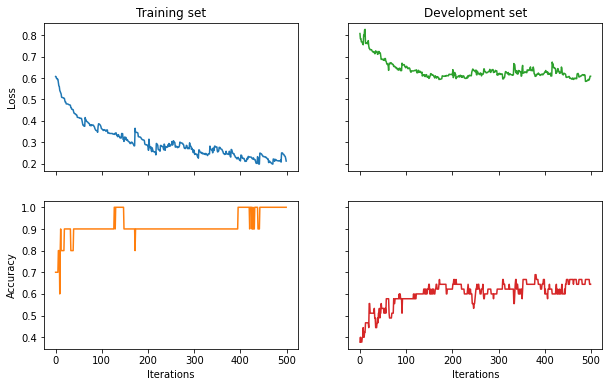

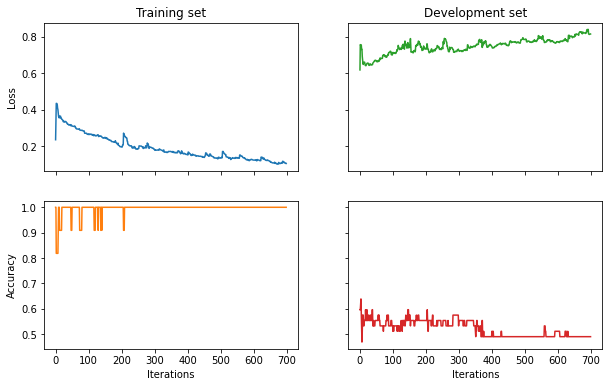

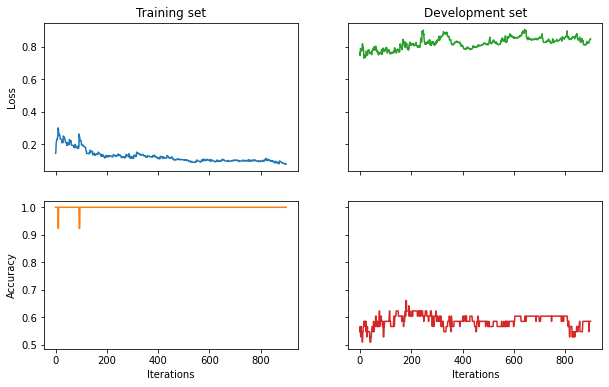

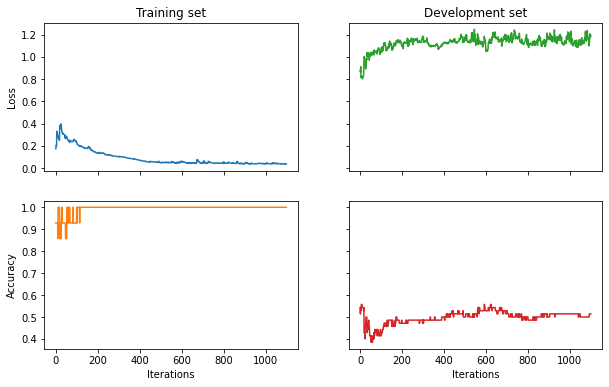

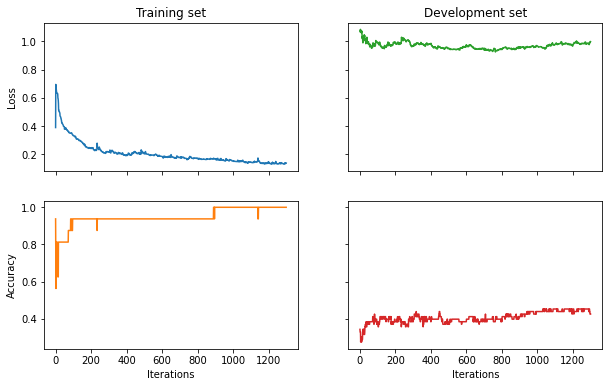

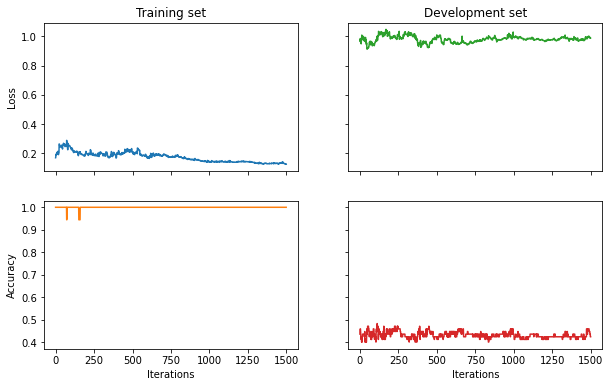

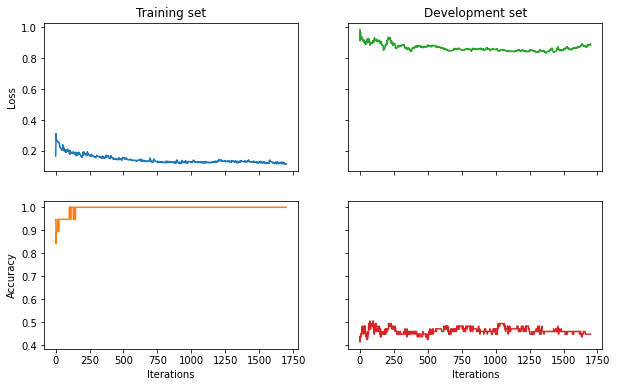

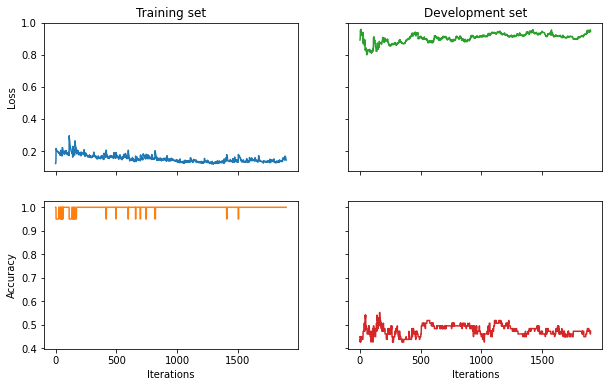

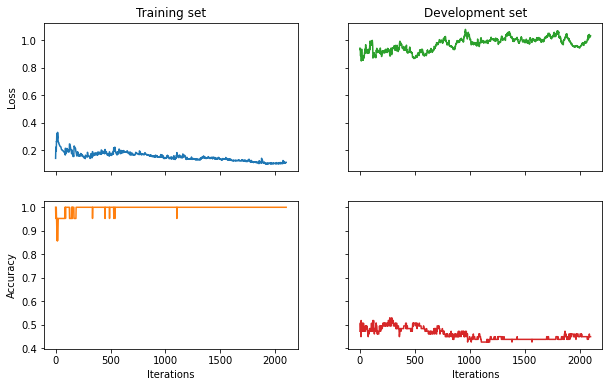

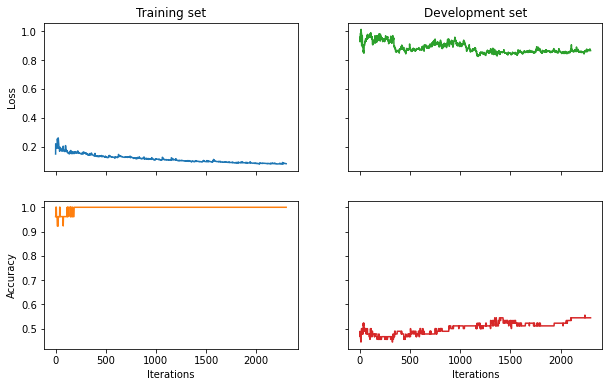

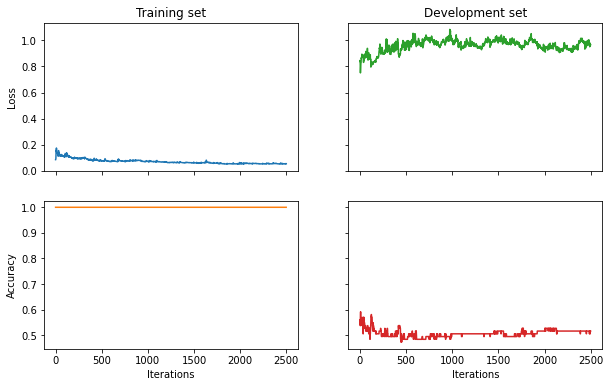

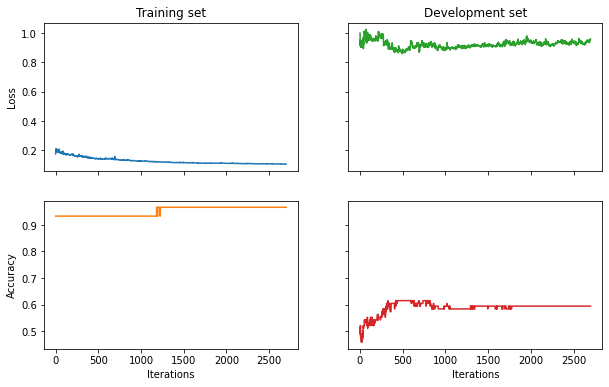

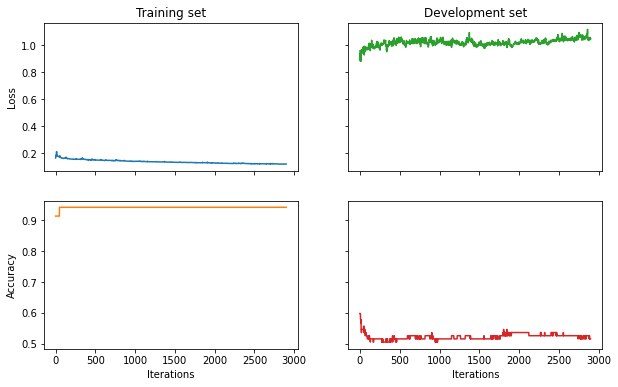

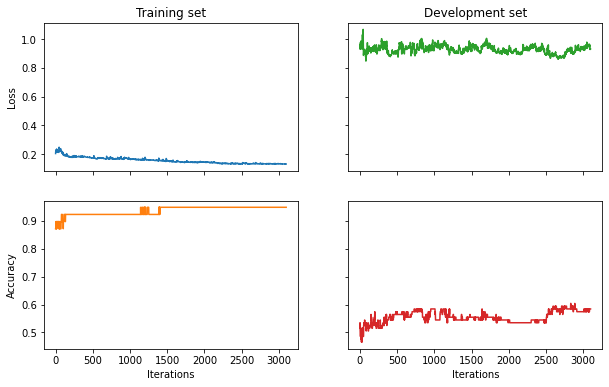

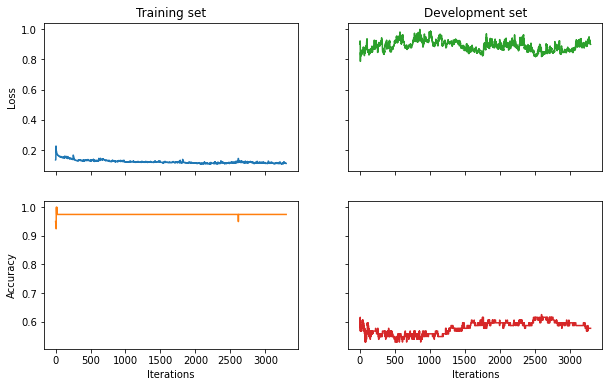

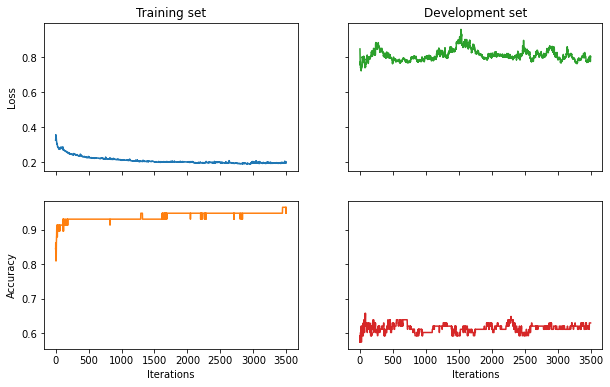

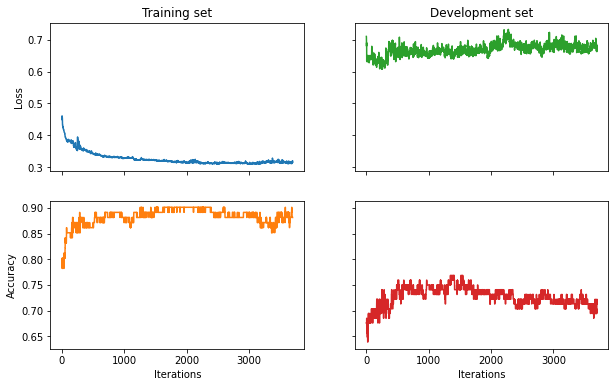

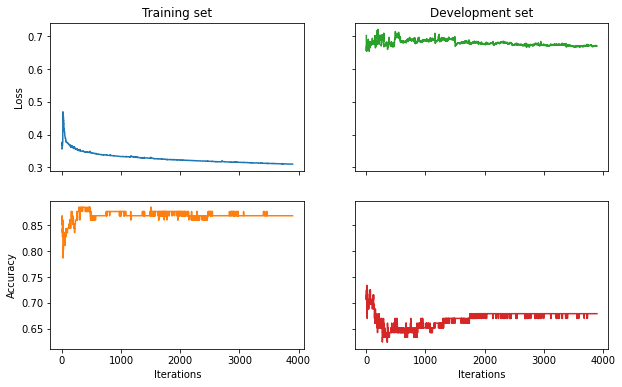

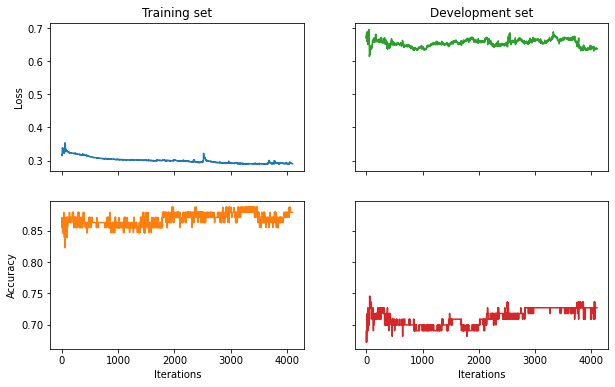

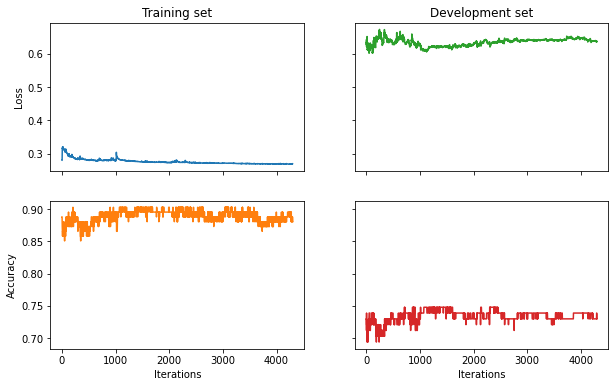

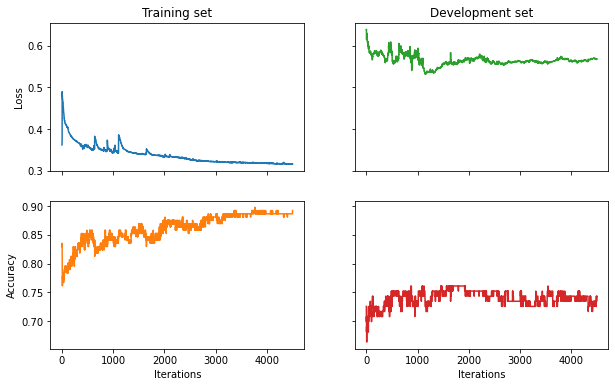

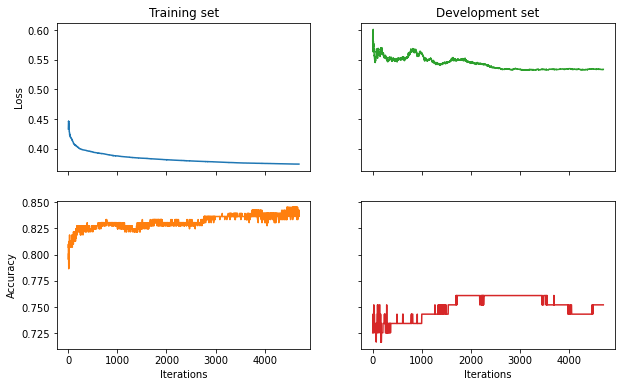

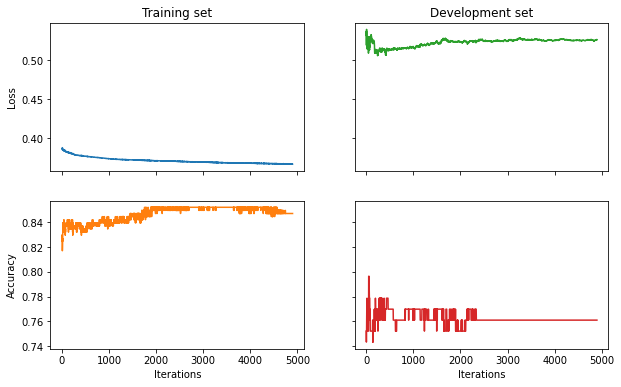

In [9]:
EPOCHS = 500
syms = {}
all_training_keys = list(training_circuits.keys())
initial_circuit_keys = all_training_keys[:10]
current_training_circuits = {}

for k in initial_circuit_keys:
    current_training_circuits[k] = training_circuits[k]
    
syms = get_symbols(current_training_circuits)
parameters = sorted(syms, key=default_sort_key)
init_params_spsa = np.array(rng.random(len(parameters)))

run = 0
for i, key in enumerate(all_training_keys[10:]):
    print("Progress: ", round((i + 10)/len(all_training_keys), 3))
    
    # Skip cases when the number of parameters did not grow when new circuits were added
    if len(syms) == len(get_symbols(current_training_circuits)) and i > 0:
        if i != len(all_training_keys[10:]):
            current_training_circuits[key] = training_circuits[key]
            new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
            parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)
            continue
    else:
        run += 1
    
    # Select those circuits from test and validation circuits which share the parameters with the current training circuits
    current_validation_circuits = select_circuits(current_training_circuits, validation_circuits)
    current_test_circuits = select_circuits(current_training_circuits, test_circuits)
    
    if len(current_validation_circuits) == 0 or len(current_test_circuits) == 0:
        continue
    
    # Create lists with circuits and their corresponding label
    training_circuits_l, training_data_labels_l = construct_data_and_labels(current_training_circuits, training_data_labels)
    validation_circuits_l, validation_data_labels_l = construct_data_and_labels(current_validation_circuits, validation_data_labels)
    test_circuits_l, test_data_labels_l = construct_data_and_labels(current_test_circuits, test_data_labels)
    
    # Limit the number of validation and test circuits to 20% of number of the training circuits
    #val_test_circ_size = ceil(len(current_training_circuits))
    #if len(current_validation_circuits) > val_test_circ_size:
    #    validation_circuits_l = validation_circuits_l[:val_test_circ_size]
    #    validation_data_labels_l = validation_data_labels_l[:val_test_circ_size]
    #if len(current_test_circuits) > val_test_circ_size:
    #    test_circuits_l = test_circuits_l[:val_test_circ_size]
    #    test_data_labels_l = test_data_labels_l[:val_test_circ_size]
    
    print(f"Number of training circuits: {len(training_circuits_l)}   ",
          f"Number of validation circuits: {len(validation_circuits_l)}   ",
          f"Number of test circuits: {len(test_circuits_l)}   ",
          f"Number of parameters in model: {len(set([sym for circuit in training_circuits_l for sym in circuit.free_symbols]))}")
    
    train_pred_fn = jit(make_pred_fn(training_circuits_l))
    dev_pred_fn = jit(make_pred_fn(validation_circuits_l))
    test_pred_fn = make_pred_fn(test_circuits_l)
    
    train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, training_data_labels_l)
    dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, validation_data_labels_l)
    
    def callback_fn(xk):
        valid_loss = dev_cost_fn(xk)
        train_loss = numpy.around(min(float(train_costs[-1]), float(train_costs[-2])), 4)
        train_acc = numpy.around(min(float(train_accs[-1]), float(train_accs[-2])), 4)
        valid_acc = numpy.around(float(dev_accs[-1]), 4)
        iters = int(len(train_accs)/2)
        if iters % 100 == 0:
            print(
                    #f"Params = {xk}, "
                    f"Epoch: {iters}   ",
                    f"train/loss: {train_loss}   ",
                    f"valid/loss: {numpy.around(float(valid_loss), 4)}   ",
                    f"train/acc: {train_acc}   ",
                    f"valid/acc: {valid_acc}", file=sys.stderr
                )
        return valid_loss
    
    a_value = 0.0053 #0.0053
    c_value = 0.00017 #0.0185
    #a_values = [0.005, 0.0051, 0.0052, 0.0053, 0.0054, 0.0055]
    #c_values = [0.00017, 0.000175, 0.00018, 0.000185, 0.00019, 0.000195]
    #for i, a_value in enumerate(a_values):
    #    for c_value in c_values:
    
    result = minimizeSPSA(train_cost_fn, x0=init_params_spsa, a = a_value, c = c_value, niter=EPOCHS, callback=callback_fn)

    figure_path = this_folder + "//results//" + workload_size + "_noisyopt_" + str(classification) + "_" + str(layers) + "_" + str(single_qubit_params) + "_" + str(run) + ".png"
    visualize_result_noisyopt(result, make_cost_fn, test_pred_fn, test_data_labels_l, train_costs, train_accs, dev_costs, dev_accs, figure_path)
    
    run += 1
    EPOCHS += 200
    syms = get_symbols(current_training_circuits)
    
    # Extend for the next optimization round
    current_training_circuits[key] = training_circuits[key]
    new_parameters = sorted(get_symbols({key: training_circuits[key]}), key=default_sort_key)
    parameters, init_params_spsa = initialize_parameters(parameters, result.x, new_parameters)